## Imports

In [142]:
import os
from bioio import BioImage
import matplotlib.pyplot as plt
import numpy as np
from tnia.deconvolution.richardson_lucy import  richardson_lucy_cp
from tnia.deconvolution.gaussian_psf import gaussian_2d

## Define paths

Define path where tg images are, path where current images interest are and image_name....

This block can be tweaked for different scenarios.

In [143]:
tg_image_path = r'D:\images\tnia-python-images\tg\2024_10_22_ts_decon'
image_path = r'_small_data_\[AS-00304]\1x1_FOVs'
image_name = r'Slide 1 - A02 - ROI 01_1x1_FOVs - DAPI.tif'

#image_path = r'_small_data_\[AS-00344]\3x3_FOVs'
#image_name = r'Slide 1 - Region 001 - ROI 02 - DAPI.tif'


## Open image 

... get image data as numpy array and inspect meta data

In [144]:
full_name = os.path.join(tg_image_path, image_path, image_name)
bioimg = BioImage(full_name)

img = np.squeeze(bioimg.data)

print(img.shape)
print(bioimg.dims.order)

print(bioimg.physical_pixel_sizes.X)
print(bioimg.physical_pixel_sizes.Y)
print(bioimg.physical_pixel_sizes.Z)

(995, 1334)
TCZYX
None
None
None


c:\Users\bnort\miniconda3\envs\decon_env_ts\lib\site-packages\bioio_tifffile\reader.py:149: UserWarning: Could not parse tiff pixel size: float division by zero
  warnings.warn(f"Could not parse tiff pixel size: {e}")


## Take a look at the data

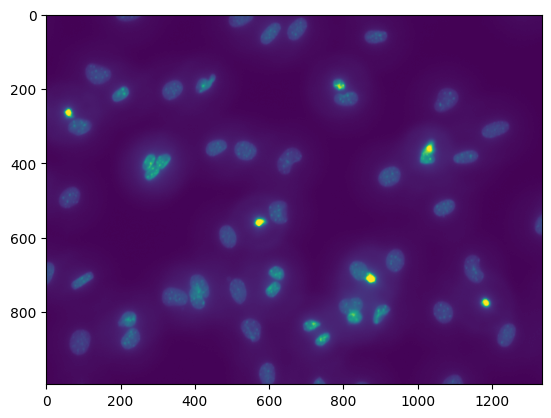

In [145]:
plt.imshow(np.squeeze(img))

In [146]:
sigma = 1
psf = gaussian_2d(129,sigma)

## Create a mask of saturated pixels

Create a mask which is 1 if the pixel is valid, but 0 if not valid (in this case saturated)

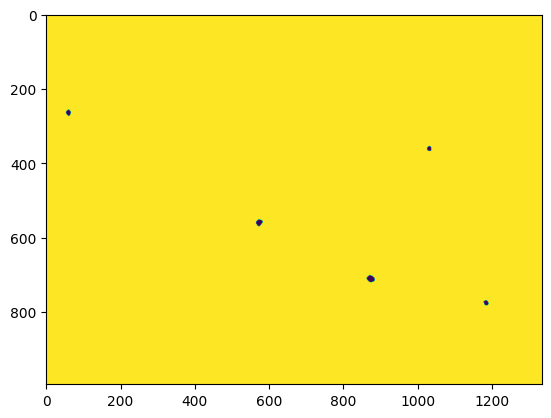

In [147]:
mask  = np.ones_like(img)
dtype = img.dtype

if dtype == np.uint8:
    mask[img==255] = 0


plt.imshow(mask)

In [148]:
from skimage.morphology import binary_dilation

decons = []
names = []
sigmas = [1,2]
num_iterations = 200

for sigma in sigmas:
    psf = gaussian_2d(33,sigma)
    decon_cp=richardson_lucy_cp(img,psf,num_iterations)
    decons.append(decon_cp)
    names.append(f'sigma={sigma}_iter={num_iterations}')
    decon_cp_saturation_masked = richardson_lucy_cp(img,psf,num_iterations,mask=mask)
    decons.append(decon_cp_saturation_masked)
    names.append(f'sigma={sigma}_iter={num_iterations}_masked')

padding psf

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
padding psf
using flat sheet

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
padding psf

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
padding psf
using flat sheet

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 


In [119]:
from skimage.io import imsave

out_path = os.path.join(tg_image_path, image_path, 'deconvolutions')

if not os.path.exists(out_path):
    os.makedirs(out_path)

for decon, name in zip(decons, names):
    imsave(os.path.join(out_path, f'{image_name}_{name}.tif'), decon)

In [149]:
import napari

viewer = napari.Viewer()
viewer.add_image(img, name='original')
for decon, name in zip(decons, names):
    viewer.add_image(decon, name=name)
